In [1]:
%load_ext autoreload
%autoreload 2

# Backpropagating values
The main idea here is that in the vicinity of a terminated trajectory (game) we can reasonably hope to find other trajectories that would also be terminated. We hope to overcome the problem of sparse rewards during RL training.

So we look at how we can generate training data for the value function from walking backward (using ```undo()```  from a game that has finally terminated in favour of one of the parties. 

In [2]:
import numpy as np

In [3]:
from wgomoku import (
    GomokuBoard, HeuristicGomokuPolicy, Heuristics, ThreatSearch,
    StochasticMaxSampler, GomokuTools as gt)

In [4]:
heuristics = Heuristics(kappa=3.0)
ts = ThreatSearch(max_depth=6, max_width=5)
p = HeuristicGomokuPolicy(bias=.5,topn=5, style=2, threat_search=ts)

In [5]:
A,B,C,D,E,F,G,H,I, J, K, L, M, N, O, P, Q, R, S, T, U = \
1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
BLACK, WHITE, EDGES = 0,1,2

In [6]:
v_vs_x = 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6l5'
stones = gt.string_to_stones(v_vs_x)
board = GomokuBoard(disp_width=10, N=19, heuristics= heuristics, stones = stones)

In [7]:
gt.stones_to_string(stones), board.game_state()

('i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6l5', 1)

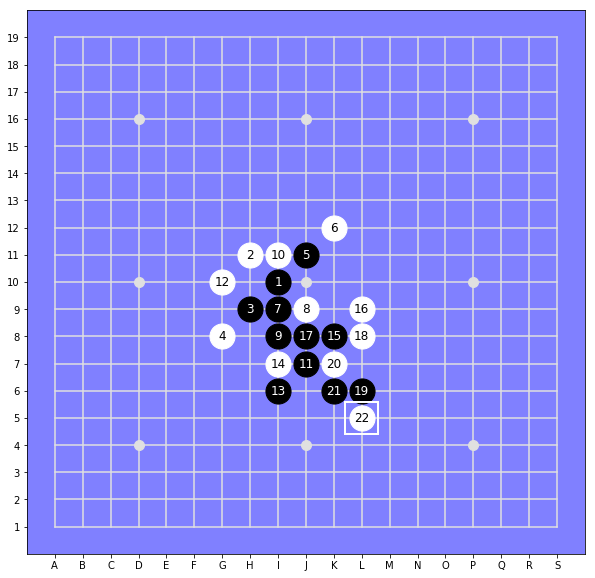

In [8]:
board.display()

In [9]:
from wgomoku import create_sample, to_matrix12

In [10]:
ts = ThreatSearch(max_depth=6, max_width=5)
p = HeuristicGomokuPolicy(bias=.5,topn=5, style=2, threat_search=ts)

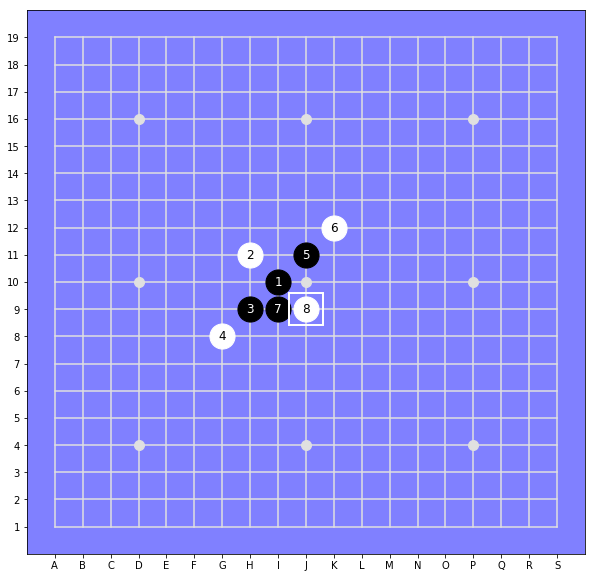

In [11]:
stones = gt.string_to_stones('i10h11h9g8j11k12i9j9')
board = GomokuBoard(disp_width=10, N=19, heuristics= heuristics, stones = stones)
board.display()

In [12]:
ts.is_tseq_won(board=board, max_depth=6, max_width=2)

([], False)

---
Now, we know that (I, 8) initiates the the winning threat sequence. Our threat search doesn't detect that in reasonable time, though.
Let's go and walk back the game trajectory and collect some determined states.

In [13]:
v_vs_x = 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6l5'
stones = gt.string_to_stones(v_vs_x)
board = GomokuBoard(disp_width=10, N=19, heuristics= heuristics, stones = stones)

In [14]:
from wgomoku import ValueTracker
tracker = ValueTracker(p)

In [15]:
newboards = tracker.register(board)
tracker, newboards

([[1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6l5']], 1)

In [16]:
while newboards: 
    board.undo()
    newboards = tracker.register(board)
tracker, newboards

([[1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6l5'], [-1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6'], [1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7'], [-1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6']],
 0)

Of course, a shorter threat search will succeed here.

In [17]:
_, won = ts.is_tseq_won(board=board, max_depth=5, max_width=3)
while won: 
    tracker.register(board, value=1)
    board.undo()
    newboards = tracker.register(board)
    if newboards:
        board.undo()
        _, won = ts.is_tseq_won(board=board, max_depth=5, max_width=3)
    else:
        break

In [18]:
tracker

[[1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6l5'], [-1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7k6'], [1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6k7'], [-1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8l6'], [1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8l8'], [-1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9j8'], [1, 'i10h11h9g8j11k12i9j9i8i11j7g10i6i7k8l9']]

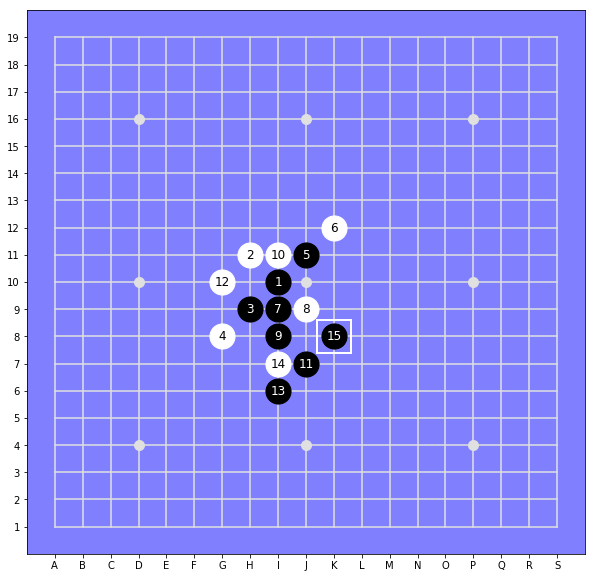

In [19]:
board.display()

In [23]:
enum = np.ndenumerate(p.probas(board=board, style=2))
sampler = StochasticMaxSampler(enum, topn=10)
choices = [ gt.m2b((x,y),19) for _, (x,y), prob, _ in sampler.choices]
[(chr(x+64), y) for x,y in choices]

[('H', 5), ('L', 9)]

In [24]:
board.set(H, 5)

In [25]:
ts.is_tseq_won(board)

([(11, 6),
  (12, 5),
  (13, 10),
  (12, 9),
  (11, 7),
  (11, 5),
  (12, 6),
  (10, 6),
  (10, 8)],
 True)